# Chapter 2: Taking Earth's Temperature

### PART I: Long-Term Evolution Back to 1850 Based on Different Data Sources <a class="anchor" id="chapter-one"></a>


In this notebook we will look at the temperature on Earth, its temporal evolution and regional differences. The notebook is organized in three chapters starting with 

1. Long-term evolution back to 1850 based on different data sources ([take me there](#chapter-one))
2. Comparison between re-analysis and observations since 1950 ([take me there](#chapter-two))
3. Recent temperature anomalies derived from ERA5 ([take me there](#chapter-three))

This tutorial requires to load data from different data sources with various spatial and temporal resolution, some of which are of several GBs, totalling about 8 GB. Therefore, we will make use of [`dask`](https://www.dask.org/) extensively. Accordingly, download and running times can sometimes be longer up to 10s of minutes. So plenty of chances to enjoy a quick break with a fresh coffee, matcha, chai, qishr or whatever your favourite drink may be.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-cams/master?labpath=vis-animations.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-cams/blob/master/vis-animations.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-cams/blob/master/vis-animations.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

In [1]:
# Python Standard Libraries
import os
import zipfile
import urllib.request

# Data Manipulation Libraries
import numpy as np
import pandas as pd
import xarray as xr
import regionmask as rm
import dask

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.diagnostics.progress import ProgressBar

# Climate Data Store API for retrieving climate data
import cdsapi

In [2]:
plt.style.use(
    "../copernicus.mplstyle"
)  # Set the visual style of the plots; not necessary for the tutorial

In [3]:
dask.config.set(**{"array.slicing.split_large_chunks": True})

In [4]:
# Boolean land-sea mask
lsm = rm.defined_regions.natural_earth_v5_0_0.land_110

In [5]:
# Define regions of interest
# =============================================================================
# Some regions are defined here: https://climate.copernicus.eu/esotc/2022/about-data#Regiondefinitions
REGIONS = {
    "Global": {"lon": slice(-180, 180), "lat": slice(-90, 90)},
    "Northern Hemisphere": {"lon": slice(-180, 180), "lat": slice(0, 90)},
    "Southern Hemisphere": {"lon": slice(-180, 180), "lat": slice(-90, 0)},
    "Europe": {"lon": slice(-25, 40), "lat": slice(34, 72)},
    "Arctic": {"lon": slice(-180, 180), "lat": slice(66.6, 90)},
}


In [7]:
# Define climatology period
# =============================================================================
REF_PERIOD = {"time": slice("1991", "2020")}

In [8]:
file_name = {}  # dictionary containing [data source : file name]

# Add the data sources and file names
file_name.update(
    {"berkeley": "temperature_berkeley.nc"}
)  # is not available as netCDF, only as zip file
file_name.update(
    {"gistemp": "temperature_gistemp.gz"}
)  # is not available as netCDF, only as zip file
file_name.update({"hadcrut": "temperature_hadcrut.nc"})
file_name.update({"era5": "temperature_era5.nc"})
file_name.update({"eobs": "temperature_eobs.tar.gz"})

# Create the paths to the files
path_to = {
    source: os.path.join(f"data/{source}/", file) for source, file in file_name.items()
}

# Create necessary directories if they do not exist
for path in path_to.values():
    os.makedirs(
        os.path.dirname(path), exist_ok=True
    )  # create the folder if not available

path_to

{'berkeley': 'data/berkeley/temperature_berkeley.nc',
 'gistemp': 'data/gistemp/temperature_gistemp.gz',
 'hadcrut': 'data/hadcrut/temperature_hadcrut.nc',
 'era5': 'data/era5/temperature_era5.nc',
 'eobs': 'data/eobs/temperature_eobs.tar.gz'}

In [9]:
def coordinate_is_monthly(ds, coord: str = "time"):
    """Return True if the coordinates are months"""
    time_diffs = np.diff(ds.coords[coord].values)
    time_diffs = pd.to_timedelta(time_diffs).days

    # If all differences are between 28 and 31 days
    if np.all((28 <= time_diffs) & (time_diffs <= 31)):
        return True
    else:
        return False

In [10]:
def streamline_coords(da):
    """Streamline the coordinates of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to streamline.
    """

    # Ensure that time coordinate is fixed to the first day of the month
    if "time" in da.coords:
        if coordinate_is_monthly(da, "time"):
            da.coords["time"] = da["time"].to_index().to_period("M").to_timestamp()

    # Ensure that spatial coordinates are called 'lon' and 'lat'
    if "longitude" in da.coords:
        da = da.rename({"longitude": "lon"})
    if "latitude" in da.coords:
        da = da.rename({"latitude": "lat"})

    # Ensure that lon/lat are sorted in ascending order
    da = da.sortby("lat")
    da = da.sortby("lon")

    # Ensure that lon is in the range [-180, 180]
    lon_min = da["lon"].min()
    lon_max = da["lon"].max()
    if lon_min < -180 or lon_max > 180:
        da.coords["lon"] = (da.coords["lon"] + 180) % 360 - 180
        da = da.sortby(da.lon)

    return da

##### NOAA GlobalTemp

Here we're going to access the data from [NOAA](https://www.ncei.noaa.gov/products/land-based-station/noaa-global-temp) using OPeNDAP. OPeNDAP is a protocol that allows for the remote access of scientific data stored in various formats over the internet. xarray is quite handy and allows to access data directly via OPENDAP. So retrieving data from NOAA basically becomes a one-liner:

In [11]:
url_to_noaa = "https://www.ncei.noaa.gov/thredds/dodsC/noaa-global-temp-v5.1/NOAAGlobalTemp_v5.1.0_gridded_s185001_e202306_c20230708T112624.nc"
noaa = xr.open_dataset(url_to_noaa)
noaa = noaa.isel(z=0, drop=True)
noaa = streamline_coords(noaa)
noaa["lsm"] = lsm.mask(noaa).notnull()

##### Berkeley Earth
Next, we set up the directory where we will download and store our data.

NOTE: In the CDS, Berkeley Earth is only available over land. We need ocean as well, so let's take the data from the official provider:  https://berkeleyearth.org/data/ Global Montly Land - Ocean, 1x1 La-Lon Grid

The data is about 400 MB so depending on your downloading speed the process may take a while.

In [ ]:
url_berkeley = 'https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Gridded/Land_and_Ocean_LatLong1.nc'
urllib.request.urlretrieve(url_berkeley, path_to['berkeley'])

In [12]:
berkeley = xr.open_dataset(path_to["berkeley"])
new_time_coords = xr.cftime_range(
    start="1850-01-01", periods=berkeley.time.size, freq="MS"
).to_datetimeindex()
berkeley.coords.update({"time": new_time_coords})
berkeley = streamline_coords(berkeley)

##### GISTEMP

We want the original gridded data (CDS only has time series), so head over to the NASA website: https://data.giss.nasa.gov/gistemp/
We download the [Land-Ocean Temperature Index, ERSSTv5, 1200km smoothing](https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz) in the following:

In [ ]:
url_gistemp_1200km = 'https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz'
url_gistemp_250km = 'https://data.giss.nasa.gov/pub/gistemp/gistemp250_GHCNv4.nc.gz'
url_gistemp_land_sea_mask = 'https://data.giss.nasa.gov/pub/gistemp/landmask.2degx2deg.txt'

urllib.request.urlretrieve(url_gistemp_1200km, 'data/gistemp/temperature_gistemp_1200km.gz')
urllib.request.urlretrieve(url_gistemp_250km, 'data/gistemp/temperature_gistemp_250km.gz')
urllib.request.urlretrieve(url_gistemp_land_sea_mask, 'data/gistemp/temperature_gistemp_land_sea_mask.txt')

In [13]:
with xr.open_dataset("data/gistemp/temperature_gistemp_1200km.gz") as gistemp_1200:
    gistemp_1200 = gistemp_1200["tempanomaly"]
with xr.open_dataset("data/gistemp/temperature_gistemp_250km.gz") as gistemp_250:
    gistemp_250 = gistemp_250["tempanomaly"]
gistemp = gistemp_250.where(gistemp_250.notnull(), other=gistemp_1200)
gistemp_lsm = pd.read_csv(
    "data/gistemp/temperature_gistemp_land_sea_mask.txt",
    sep="\s+",
    header=1,
    names=["lon", "lat", "mask"],
)
gistemp_lsm = gistemp_lsm.set_index(["lat", "lon"])
gistemp_lsm = gistemp_lsm.to_xarray()
gistemp = xr.merge([gistemp, gistemp_lsm["mask"]])
gistemp = streamline_coords(gistemp)

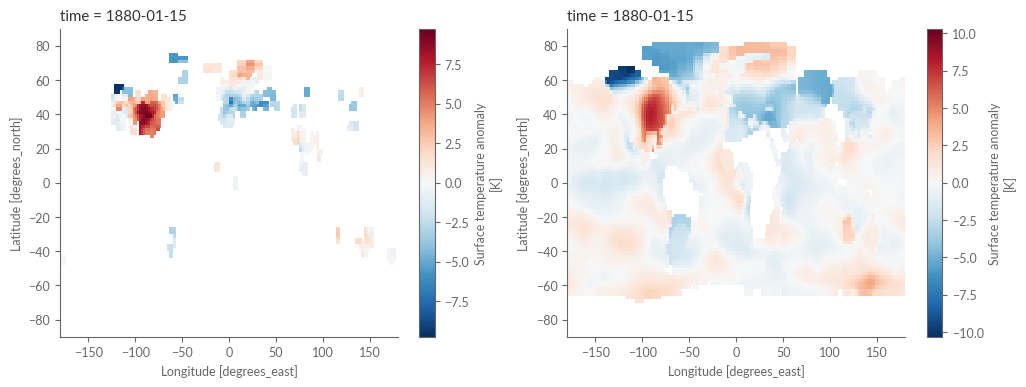

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
gistemp_250.isel(time=0).plot(ax=axes[0])
gistemp_1200.isel(time=0).plot(ax=axes[1])

##### HadCRUT5

HadCRUT5 also provides direct access to its individual ensemble members (200 in total). The idea behind the ensemble members is that they catch the sensitivity to initial conditions and thus the underlying uncertainty of the model. Each ensemble member is a slighlty different realization. Here we just download the first 10 members (~300 MB) of the 200 to save up some computational and memory time. Ideally, you want to run the following lines with all 200 members. First, let's get the first batch of ensemble members:

In [ ]:
with zipfile.ZipFile('data/hadcrut/temperature_ensemble_members.zip') as z:
    z.extractall('data/hadcrut/')

In [15]:
with xr.open_dataset(path_to["hadcrut"]) as hadcrut:
    pass
with xr.open_dataset("data/hadcrut/temperature_weights.nc") as hadcrut_weights:
    pass
hadcrut_members = xr.open_mfdataset(
    "data/hadcrut/*analysis*.nc", combine="nested", concat_dim="realization"
)
hadcrut_members = hadcrut_members.compute()
hadcrut = xr.Dataset(
    {
        "mean": hadcrut["tas_mean"],
        "weights": hadcrut_weights["weights"],
        "ensemble": hadcrut_members["tas"],
    }
)
hadcrut = streamline_coords(hadcrut)

##### ERA5 reanalysis

Now, let's retrieve our data from the CDS using the `cdsapi.Client()`. Here, we download the reanalysis ERA5 single levels monthly means data for the variable '2m_temperature' from 1950 to 2022.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    For efficiency and to expedite processing time, we are opting to download the data at a coarser resolution of 1x1 degree, as opposed to the highest (default) resolution of 0.25x0.25 degree. Please be aware that this could lead to minor discrepancies when compared to figures published in <a href="https://climate.copernicus.eu/climate-bulletins">climate intelligence bulletins.</a>
</div>

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    Please note that the time to request and download the data may vary as it depends on several factors. It typically should take less than 10 minutes though.
</div>

In [ ]:
c = cdsapi.Client()

c.retrieve(
  'reanalysis-era5-single-levels-monthly-means',
  {
    'format': 'netcdf',
    'product_type': 'monthly_averaged_reanalysis',
    'variable': ['2m_temperature', 'land_sea_mask'],
    'year': list(range(1950, 2023)),
    'month': list(range(1, 13)),
    'time': '00:00',
    # 'grid': [0.25, 0.25],
  },
  path_to['era5']
)

In [16]:
with xr.open_mfdataset(path_to["era5"]) as era5:
    # convert from Kelvin to Celsius
    era5["t2m"] = era5["t2m"] - 273.15
era5 = streamline_coords(era5)
era5_monthly_climatology = era5["t2m"].sel(REF_PERIOD).groupby("time.month").mean()
era5["anom"] = era5["t2m"].groupby("time.month") - era5_monthly_climatology


/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 73 times more chunks
  return self.array[key]


Good to know: When dealing with temperature anomalies, the focus is on the change in temperature from a baseline or reference value, rather than the absolute temperature itself. This means we're interested in the difference or deviation from a reference point, which remains the same regardless of whether the temperature scale is Celsius, Kelvin, or Fahrenheit.

#### Limited spatial coverage in the past can lead to biases

Text(0.5, 1.0, '1950')

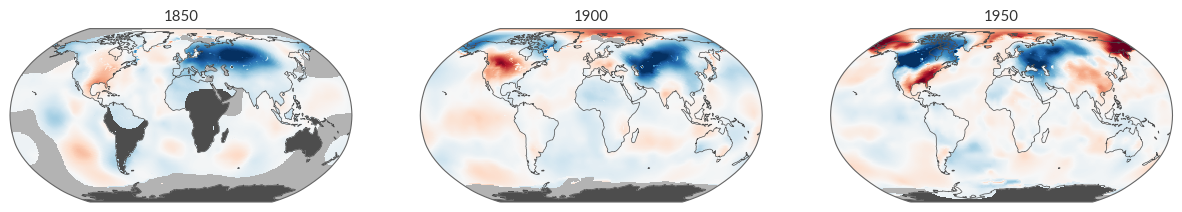

In [17]:
# Note that the farer back in time we go, the less of the globe is covered by the data illustrating the limited in-situ measurements available in the prior centuries.
fig = plt.figure(figsize=(15, 5))
ax = [plt.subplot(1, 3, i+1, projection=ccrs.Robinson()) for i in range(3)]
kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-8, vmax=8, add_colorbar=False)
berkeley['temperature'].sel(time='1850-01').plot(ax=ax[0], **kwargs)
berkeley['temperature'].sel(time='1900-01').plot(ax=ax[1], **kwargs)
berkeley['temperature'].sel(time='1950-01').plot(ax=ax[2], **kwargs)
for a in ax:
    a.coastlines(lw=.5, color='.3')
    a.add_feature(cfeature.LAND, lw=.5, color='.3')
    a.add_feature(cfeature.OCEAN, lw=.5, color='.7')
    a.set_global()
    a.set_title('')
ax[0].set_title('1850', loc='center')
ax[1].set_title('1900', loc='center')
ax[2].set_title('1950', loc='center')

Note that at the beginning of the instrumental period, the temperature data has considerable gaps around the globe. This is due to the limited number of in-situ measurements available at that time. The coverage increases over time as more and more measurements become available. However, the reduced spatial coverage in the past, especially so in the Southern Hemisphere, can lead to biases which should be reflected in the associated uncertainties.

In [18]:
def weighted_spatial_average(da, region, land_mask=None):
    """Calculate the weighted spatial average of a DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The DataArray to average.
    weights : xr.DataArray, optional
        A DataArray with the same dimensions as `da` containing the weights.
    """
    da = da.sel(**region)

    # Area weighting: calculate the area of each grid cell
    weights = np.cos(np.deg2rad(da.lat))

    # Additional user-specified weights, e.g. land-sea mask
    if land_mask is not None:
        land_mask = land_mask.sel(**region)
        weights = weights * land_mask.fillna(0)

    return da.weighted(weights).mean(("lat", "lon"))

In [19]:
region = "Arctic"

temps = {
    "HadCRUT": hadcrut["mean"],
    "HadCRUT_ensemble": hadcrut["ensemble"],
    "Berkeley": berkeley["temperature"],
    "GISTEMP": gistemp["tempanomaly"],
    "NOAA": noaa["anom"],
    "ERA5": era5["t2m"],
}
land_masks = {
    "HadCRUT": hadcrut["weights"],
    "HadCRUT_ensemble": hadcrut["weights"],
    "Berkeley": berkeley["land_mask"],
    "GISTEMP": gistemp["mask"],
    "NOAA": noaa["lsm"],
    "ERA5": era5["lsm"],
}


In [20]:
temp_evolution = {}
for source in temps:
    spatial_average = weighted_spatial_average(
        temps[source], REGIONS[region], land_masks[source]
    )
    with ProgressBar():
        temp_evolution[source] = spatial_average.compute()
temp_evolution = xr.Dataset(temp_evolution)

# Show anomalies with respect to the 1991-2020 climatology
temp_evolution = temp_evolution - temp_evolution.sel(REF_PERIOD).mean("time")

[####                                    ] | 10% Completed | 61.11 sms

In [21]:
temp_evolution_smooth = temp_evolution.rolling(time=60, center=True).mean()

anom_1850_1900 = temp_evolution_smooth.drop_vars("HadCRUT_ensemble").sel(
    time=slice("1850", "1900")
)
mean_1850_1900 = anom_1850_1900.to_array().mean()

In [22]:
confidence_interval = temp_evolution_smooth["HadCRUT_ensemble"].quantile([0.0, 1.0], dim="realization")

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


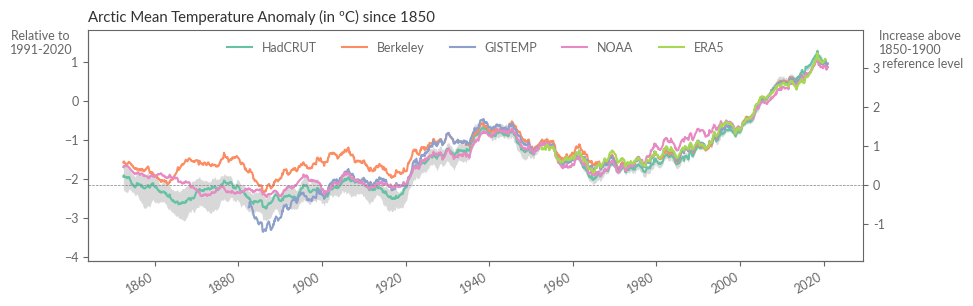

In [23]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
temp_evolution_smooth["HadCRUT"].plot(ax=ax, label="HadCRUT")
temp_evolution_smooth["Berkeley"].plot(ax=ax, label="Berkeley")
temp_evolution_smooth["GISTEMP"].plot(ax=ax, label="GISTEMP")
temp_evolution_smooth["NOAA"].plot(ax=ax, label="NOAA")
temp_evolution_smooth["ERA5"].plot(ax=ax, label="ERA5")
ax.fill_between(
    confidence_interval.time,
    confidence_interval.sel(quantile=0.0),
    confidence_interval.sel(quantile=1.0),
    color=".7",
    alpha=0.5,
    lw=0,
    zorder=-1,
)
ax.legend(ncols=6, frameon=False, loc="upper center")


ax2.spines["right"].set_visible(True)
ax2.spines["top"].set_visible(True)
ax.xaxis.set_major_locator(mdates.YearLocator(20))

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title(f"{region} Mean Temperature Anomaly (in ºC) since 1850")
ax.text(
    -0.02,
    1,
    "Relative to \n1991-2020",
    rotation=0,
    ha="right",
    va="top",
    transform=ax.transAxes,
)
ax.text(
    1.02,
    1,
    "Increase above \n1850-1900\n reference level",
    rotation=0,
    ha="left",
    va="top",
    transform=ax.transAxes,
)
ax.axhline(mean_1850_1900, color=".5", lw=0.5, ls="--")

yticks = np.arange(-10, 10, 1)
ax2_yticks = yticks + mean_1850_1900.item()
ax2.set_yticks(ax2_yticks)
ax2.set_yticklabels(yticks)
ax.set_ylim(-4.1, 1.8)
ax2.set_ylim(-4.1, 1.8)

plt.show()

In [24]:
# Taking Earth's mean temperature
region = "Europe"
land_mask = era5["lsm"]
clim_temp_era5 = era5["t2m"].sel(REF_PERIOD)
clim_temp_era5 = weighted_spatial_average(
    clim_temp_era5, REGIONS[region], land_mask=land_mask
)

with ProgressBar():
    clim_temp_era5 = clim_temp_era5.compute()

# Weithed temporal mean taking into account the number of days in each month over climatology period
dim = clim_temp_era5.time.dt.days_in_month
clim_temp_era5 = (clim_temp_era5 * dim).sum() / dim.sum()
print(clim_temp_era5)

[########################################] | 100% Completed | 93.53 s
<xarray.DataArray ()>
array(9.34547239)
